In [1]:
import importlib.util
import os
from copy import copy
from io import StringIO
from logging import (
    INFO,
    NOTSET,
    FileHandler,
    Formatter,
    Logger,
    StreamHandler,
    captureWarnings,
    getLogger,
)
from pathlib import Path
from shutil import rmtree

import matplotlib.pyplot as plt
import numpy as np
from ase.build import molecule
from ase.geometry import get_dihedrals
from ase.io import write
from ase.io.trajectory import Trajectory
from ase.vibrations import Vibrations
from ase.visualize import view
from fairchem.core import FAIRChemCalculator
from fairchem.core.units.mlip_unit import load_predict_unit
from sella import IRC, Sella

/home/yu9824/opt/miniforge3/envs/fairchem312/lib/python3.12/site-packages/torchtnt/utils/version.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
jobname = "ethane-irc"

SEED = 334

In [3]:
if "__file__" in locals():
    DIRPATH_ROOT = Path(__file__).parent
else:
    DIRPATH_ROOT = Path(os.getcwd())

DIRPATH_TRAJ = DIRPATH_ROOT / "traj" / jobname
rmtree(DIRPATH_TRAJ, ignore_errors=True)
DIRPATH_TRAJ.mkdir(parents=True)

DIRPATH_LOG = DIRPATH_ROOT / "log" / jobname
rmtree(DIRPATH_LOG, ignore_errors=True)
DIRPATH_LOG.mkdir(parents=True)

DIRPATH_OUT = DIRPATH_ROOT / "out"
DIRPATH_OUT.mkdir(exist_ok=True)

In [4]:
def configure_logger() -> Logger:
    logger = getLogger("sella-tutorial")
    logger.propagate = False

    formatter = Formatter("%(asctime)s [%(levelname)s] %(message)s")

    file_handler = FileHandler(
        DIRPATH_LOG / "sella-tutorial.log",
        mode="w",  # 上書き
    )
    file_handler.setFormatter(formatter)
    file_handler.setLevel(NOTSET)

    if importlib.util.find_spec("colorlog"):
        from colorlog import ColoredFormatter

        colored_formatter = ColoredFormatter(
            "%(asctime)s [%(log_color)s%(levelname)s%(reset)s] %(message)s"
        )
    else:
        colored_formatter = formatter
    stream_handler = StreamHandler()
    stream_handler.setFormatter(colored_formatter)
    stream_handler.setLevel(NOTSET)

    captureWarnings(True)
    _logger_warnings = getLogger("py.warnings")
    _logger_warnings.handlers.clear()
    _logger_warnings.addHandler(file_handler)
    _logger_warnings.addHandler(stream_handler)
    _logger_warnings.propagate = False

    logger.handlers.clear()
    logger.addHandler(file_handler)
    logger.addHandler(stream_handler)
    logger.setLevel(INFO)

    return logger


logger = configure_logger()

In [5]:
predictor = load_predict_unit(
    Path(os.environ["HOME"]) / "uma/checkpoints/uma-s-1p1.pt", device="cuda"
)
calc = FAIRChemCalculator(predictor, task_name="omol", seed=SEED)

In [6]:
# --- 0) ユーティリティ：Cと各Cに結合するHを見つける
def find_ch_groups(atoms, cutoff=1.3):
    positions = atoms.get_positions()
    symbols = atoms.get_chemical_symbols()
    C_idx = [i for i, s in enumerate(symbols) if s == "C"]
    H_idx = [i for i, s in enumerate(symbols) if s == "H"]
    # 簡易に距離でC-H結合を判定
    ch = {c: [] for c in C_idx}
    for c in C_idx:
        for h in H_idx:
            d = np.linalg.norm(positions[c] - positions[h])
            if d < cutoff:
                ch[c].append(h)
    C0, C1 = C_idx
    Hs0, Hs1 = ch[C0], ch[C1]
    # 各メチルから1つHを選び、H–C–C–Hの二面角を定義
    # return C0, C1, Hs0[0], Hs1[0]
    return C0, C1, Hs0, Hs1

In [7]:
# --- 1) 初期/最終構造の用意（エタン）
ethane = molecule("C2H6")  # 初期に一旦作成
C0, C1, Hs0, Hs1 = find_ch_groups(ethane)

ts_cand = ethane.copy()
view(ts_cand, viewer="x3d")

In [8]:
# --- ヘルパー関数: dihedral angle を degree で返す
def dihedral_angle(atoms, i, j, k, l):
    pos = atoms.get_positions()
    v0 = pos[j] - pos[i]  # i->j
    v1 = pos[k] - pos[j]  # j->k
    v2 = pos[l] - pos[k]  # k->l
    return get_dihedrals([v0], [v1], [v2])[0]  # degree


mask = tuple(ind in set(Hs1) | {C0, C1} for ind in range(len(ethane)))

target_ts_dihed = 0.0
ts_cand.set_dihedral(
    Hs0[0],
    C0,
    C1,
    Hs1[0],
    target_ts_dihed,
    mask=mask,
)
view(ts_cand, viewer="x3d")

In [9]:
ts_structure = ts_cand.copy()
ts_structure.calc = copy(calc)
ts_structure.info["charge"] = 0
ts_structure.info["spin"] = 1
opt_ts = Sella(
    ts_structure,
    trajectory=str(DIRPATH_TRAJ / "ts.traj"),
    logfile=str(DIRPATH_LOG / "ts.log"),
    order=1,  # ← index-1 saddle を探す
    eta=1e-4,  # 初期ステップサイズ。大きくすると高速に移動、小さくすると安定だが遅い
    gamma=0.001,  # 反復パラメータ（Sella 固有）。勾配の反映具合を調整
    internal=False,  # 内部座標系で最適化するか。False で Cartesian 最適化
    diag_every_n=1,
)
converged_ts = opt_ts.run(fmax=0.001)
logger.info(f"Converge ts structure: {converged_ts}")

view(ts_structure, viewer="x3d")

2025-08-21 16:49:06,258 [INFO] Converge ts structure: True


In [10]:
#  振動数計算
dirpath_vib_cache = DIRPATH_TRAJ / "cache"

# 遷移状態の構造を読み込み
# ts_structure = read("ts.traj", index=-1)  # 最後の構造を取得
ts_structure.calc = copy(calc)
ts_structure.info["charge"] = 0
ts_structure.info["spin"] = 1

# 振動数計算の設定
vib = Vibrations(
    ts_structure, delta=0.01, name=str(dirpath_vib_cache), nfree=2
)  # delta: 有限差分のステップサイズ（Å）

vib.clean()
# 振動数計算を実行
vib.run()

frequencies = vib.get_frequencies()
flag_imag_freq = ~np.isclose(frequencies.imag, 0.0)
n_imag_freqs = np.sum(flag_imag_freq).item()
# 結果の表示
logger.info("=== 振動数計算結果 ===")
logger.info(f"虚振動の数: {n_imag_freqs} / {flag_imag_freq.shape[0]}")

# 虚振動数の詳細表示
str_imag_freqs = "虚振動数 (cm^-1):"
if n_imag_freqs:
    for idx, freq in enumerate(frequencies):
        if flag_imag_freq[idx]:
            str_imag_freqs += f"\n  {idx}: {freq:8.2f}"
            # 虚振動のモードを可視化
            vib.write_mode(idx)
            (
                dirpath_vib_cache.parent
                / f"{dirpath_vib_cache.name}.{idx}.traj"
            ).rename(dirpath_vib_cache.parent / f"{jobname}.{idx}.traj")

    logger.info(str_imag_freqs)

buffer_io = StringIO()
vib.summary(log=buffer_io)
logger.info(f"\n{buffer_io.getvalue()}")

2025-08-21 16:49:10,790 [INFO] === 振動数計算結果 ===
2025-08-21 16:49:10,791 [INFO] 虚振動の数: 4 / 24
2025-08-21 16:49:10,809 [INFO] 虚振動数 (cm^-1):
  0: 0.00+294.07j
  1: 0.00+20.53j
  2: 0.00+7.57j
  3: 0.00+7.37j
2025-08-21 16:49:10,810 [INFO] 
---------------------
  #    meV     cm^-1
---------------------
  0   36.5i    294.1i
  1    2.5i     20.5i
  2    0.9i      7.6i
  3    0.9i      7.4i
  4    0.0       0.2
  5    0.0       0.2
  6    0.1       1.0
  7  110.8     893.6
  8  110.8     893.6
  9  126.1    1016.9
 10  144.7    1167.4
 11  144.7    1167.4
 12  173.3    1397.9
 13  177.9    1434.8
 14  185.1    1492.7
 15  185.1    1493.0
 16  186.2    1501.8
 17  186.2    1502.1
 18  379.8    3063.2
 19  380.7    3070.6
 20  386.1    3114.4
 21  386.2    3114.7
 22  388.9    3136.5
 23  388.9    3136.8
---------------------
Zero-point energy: 2.021 eV



In [11]:
ind = 0
traj_vib = Trajectory(DIRPATH_TRAJ / f"{jobname}.{ind}.traj")
# write(f"vib.{ind}.gif", traj_vib, format="gif")
view(traj_vib, viewer="ngl")

In [12]:
ts_irc_forward = ts_structure.copy()
ts_irc_forward.calc = copy(calc)
ts_irc_forward.info["charge"] = 0
ts_irc_forward.info["spin"] = 1

opt_irc_forward = IRC(
    ts_irc_forward,
    logfile=str(DIRPATH_LOG / "irc_forward.log"),
    trajectory=str(DIRPATH_TRAJ / "irc_forward.traj"),
    eta=1e-4,  # 初期ステップサイズ。大きくすると高速に移動、小さくすると安定だが遅い
    gamma=0.01,  # 反復パラメータ（Sella 固有）。勾配の反映具合を調整
)
converged_irc_forward = opt_irc_forward.run(
    fmax=0.01,
    steps=10000,
    direction="forward",
)
logger.info(f"Converged IRC (foward): {converged_irc_forward}")

traj_forward = Trajectory(str(DIRPATH_TRAJ / "irc_forward.traj"))
view(traj_forward, viewer="ngl")

2025-08-21 16:49:10,998 [WARNING] /home/yu9824/opt/miniforge3/envs/fairchem312/lib/python3.12/site-packages/sella/peswrapper.py:325: RuntimeWarning: invalid value encountered in scalar divide
  ratio = df_actual / df_pred

2025-08-21 16:49:14,689 [INFO] Converged IRC (foward): True


In [13]:
ts_irc_reverse = ts_structure.copy()
ts_irc_reverse.calc = copy(calc)
ts_irc_reverse.info["charge"] = 0
ts_irc_reverse.info["spin"] = 1

opt_irc_reverse = IRC(
    ts_irc_reverse,
    logfile=str(DIRPATH_LOG / "irc_reverse.log"),
    trajectory=str(DIRPATH_TRAJ / "irc_reverse.traj"),
    eta=1e-4,  # 初期ステップサイズ。大きくすると高速に移動、小さくすると安定だが遅い
    gamma=0.01,  # 反復パラメータ（Sella 固有）。勾配の反映具合を調整
)
converged_irc_reverse = opt_irc_reverse.run(
    fmax=0.01,
    steps=10000,
    direction="reverse",
)
logger.info(f"Converged IRC (reverse): {converged_irc_reverse}")

traj_reverse = Trajectory(str(DIRPATH_TRAJ / "irc_reverse.traj"))
view(traj_reverse, viewer="ngl")

2025-08-21 16:49:18,909 [INFO] Converged IRC (reverse): True


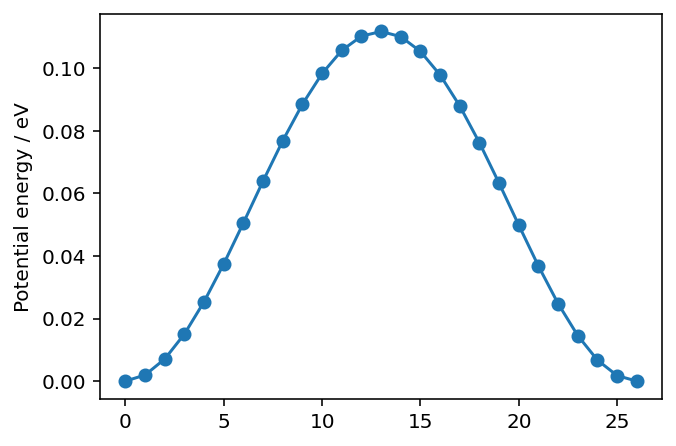

In [14]:
tup_atoms_irc = tuple(traj_reverse)[::-1] + tuple(traj_forward[1:])
energies = np.array(
    [_atoms.get_potential_energy() for _atoms in tup_atoms_irc]
)
energies -= energies.min()

fig, ax = plt.subplots(dpi=144, figsize=(4.8, 3.2))
ax.plot(energies, marker="o")
ax.ticklabel_format(style="plain", useOffset=False)
ax.set_ylabel("Potential energy / eV")
fig.tight_layout()

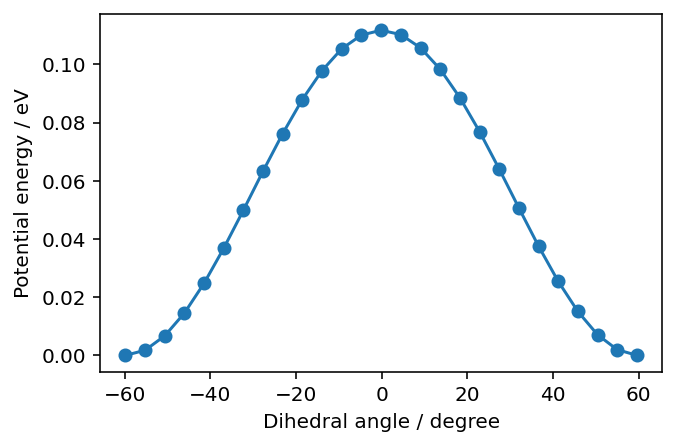

In [15]:
arr_dihedral_angles = np.asarray(
    [
        dihedral_angle(tup_atoms_irc[frame], Hs0[0], C0, C1, Hs1[0])
        for frame in range(len(tup_atoms_irc))
    ]
)
arr_dihedral_angles[arr_dihedral_angles > 180] -= 360

fig, ax = plt.subplots(dpi=144, figsize=(4.8, 3.2))
ax.plot(arr_dihedral_angles, energies, marker="o")
ax.ticklabel_format(style="plain", useOffset=False)
ax.set_xlabel("Dihedral angle / degree")
ax.set_ylabel("Potential energy / eV")
fig.tight_layout()

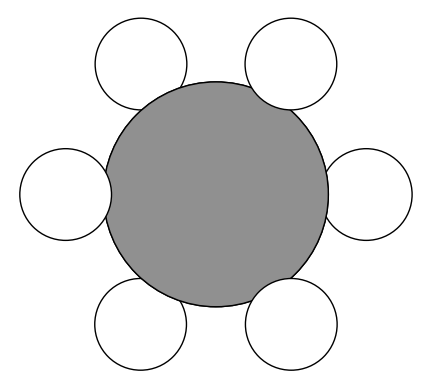

In [16]:
write(str(DIRPATH_OUT / f"{jobname}.gif"), tup_atoms_irc, format="gif")